In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 9.3MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 204kB 18.8MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
Mounted at /content/gdrive


In [5]:
from fastbook import *
from fastai.vision.widgets import *

In [7]:
from fastai.vision.all import *

In [8]:
!pip install -q jmd_imagescraper  #installing imagescraper

In [9]:
from jmd_imagescraper.core import *
from pathlib import Path

In [10]:
path = Path().cwd()/"test_images" #setting up a new path and changing work directory to test_images

In [11]:
if path.exists():
    import shutil
    shutil.rmtree(path)     #deleting any previously downloaded files in path

In [12]:
n_images = 100  #total number of images to download per search term
search_terms = ["tacos", 'burgers','fries'] # list of terms to be searched for.



In [13]:
for term in search_terms:
  duckduckgo_search(path, '_'.join(term.split()), term, max_results = n_images) #searching for and downloading the images

Duckduckgo search: tacos


Duckduckgo search: burgers


Duckduckgo search: fries


In [14]:
files = get_image_files(path)  
len(files)

300

In [15]:
files

(#300) [Path('/content/test_images/fries/024_b6764b7e.jpg'),Path('/content/test_images/fries/098_15182cdc.jpg'),Path('/content/test_images/fries/066_73549d55.jpg'),Path('/content/test_images/fries/033_5bd60ad8.jpg'),Path('/content/test_images/fries/057_369e4419.jpg'),Path('/content/test_images/fries/082_ab465ae7.jpg'),Path('/content/test_images/fries/059_63faca47.jpg'),Path('/content/test_images/fries/067_1b11270b.jpg'),Path('/content/test_images/fries/040_94257a42.jpg'),Path('/content/test_images/fries/013_9ecb2dcd.jpg')...]

In [19]:
params = {
    'max_results': 3,
    'img_size': ImgSize.Medium,
    'img_type': ImgType.Photo,
    'img_layout': ImgLayout.All,
    'img_color': ImgColor.Purple
}

link = duckduckgo_scrape_urls('burger', max_results=1)  #scraping a url for the eventual purpose of downloading a file.
link

['https://tse3.mm.bing.net/th?id=OIP.y4PaZXkg6UGVIJ1F_6k-HwHaHa&pid=Api']

In [20]:
root = Path.cwd()/'images'
download_urls(root/'burgers', link) #downloading a single image into the file labelled burgers.


[Path('/content/images/burgers/001_48ba42e6.jpg')]

In [21]:
dest = 'images/burgers/001_48ba42e6.jpg'

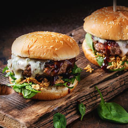

In [22]:
im = Image.open(dest)  
im.to_thumb(128,128)     # viewing an image.

In [24]:
failed = verify_images(files) #uncovering the names of files that are corrupt

In [25]:
failed

(#0) []

In [26]:
failed.map(Path.unlink)  #removing the incorrectly downloaded files from the folders.

(#0) []

In [30]:
fastfood = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))    # Setting up the various parameters to be applied to the data.


In [31]:
dls = fastfood.dataloaders(path) #dataloader converts the data into a training and validation set as well as applies other changes specified in the datablock api. 

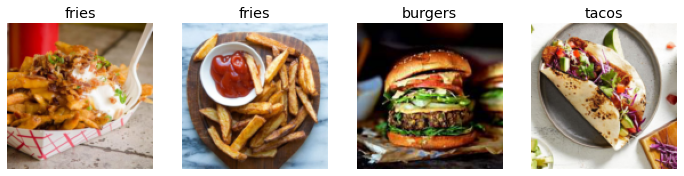

In [32]:
dls.valid.show_batch(max_n=4, nrows=1)

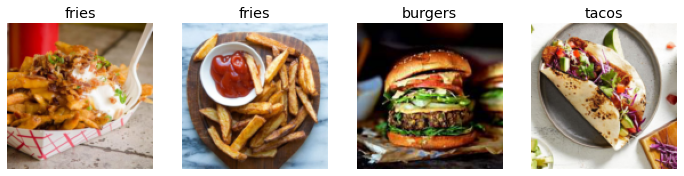

In [34]:
fastfood= fastfood.new(item_tfms=Resize(128, ResizeMethod.Squish))  # transforming the dataset by squish method.
dls = fastfood.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

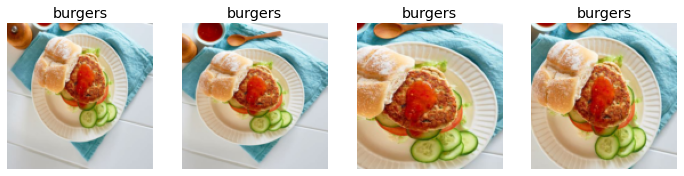

In [37]:
fastfood = fastfood.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = fastfood.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

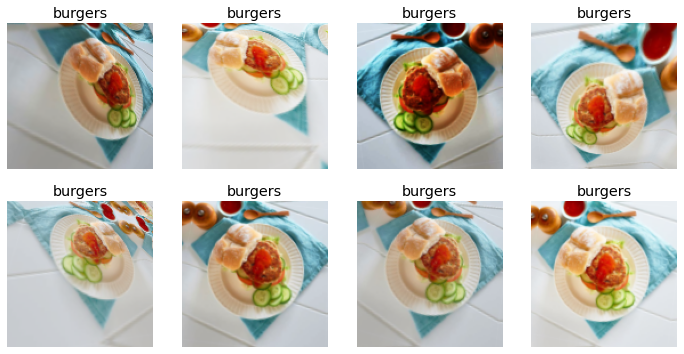

In [38]:
fastfood = fastfood.new(item_tfms=Resize(128), batch_tfms = aug_transforms(mult=2))
dls = fastfood.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [42]:
fastfood = fastfood.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())  # changing the transformation applied to data.
dls = fastfood.dataloaders(path)  # siphoning off the data into a training and validation set

In [43]:
learn = cnn_learner(dls, resnet18, metrics =error_rate) 
learn.fine_tune(4) # training the model on training set.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


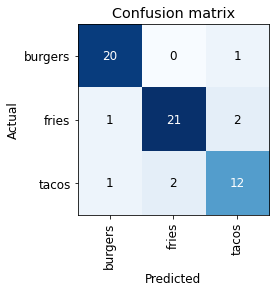

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

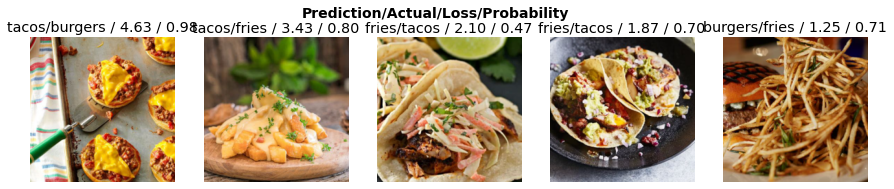

In [45]:
interp.plot_top_losses(5, nrows=1) # images with the highest loss function

In [46]:
cleaner = ImageClassifierCleaner(learn) #searching the valid and training data for incorrectly labelled files to address any errors in training.
cleaner 

In [47]:
learn.export() #saving the model and its parameters for future use

In [48]:
path = Path()
path.ls(file_exts='.pkl') #checking the presence of the saved model in path location

(#1) [Path('export.pkl')]

In [49]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/burgers/001_48ba42e6.jpg') #using the model to make predictions

('burgers', tensor(0), tensor([1.0000e+00, 3.7776e-10, 9.8487e-09]))

In [50]:
learn_inf.dls.vocab # listing the categories

['burgers', 'fries', 'tacos']